<a href="https://colab.research.google.com/github/aozengi/TR2EN/blob/main/seq2seq_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kütüphaneleri İçe Aktarma

In [27]:
import numpy as np
import pandas as pd
import sklearn as sk
import keras
import matplotlib
import nltk
import platform
import string
import time
import datetime
import os
import requests
from numpy import array, argmax, random, take
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import defaultdict

## Donanım ve Kütüphane Bilgileri

Proje kapsamında modelin oluşturularak derlendiği ve eğitildiği donanımın işletim sistemi, işlemci ve RAM bilgileri aşağıdaki gibidir. Aynı zamanda Python ve kütüphane versiyon bilgileri de aşağıda verilmiştir.

In [28]:
if platform.system() == "Darwin":
    ram_value = f"{int((int(os.popen('sysctl hw.memsize').read().split(': ')[1]) / (2**30))):.0f} GB"
elif platform.system() == "Windows":
    ram_value = f"{int((int(os.popen('wmic memorychip get capacity').read().split(': ')[1]) / (2**30))):.0f} GB"
elif platform.system() == "Linux":
    with open('/proc/meminfo', 'r') as mem:
        total_memory = int(mem.readline().split()[1])
        ram_value = f"{total_memory // (1024*1024)} GB"
else:
    ram_value = "N/A"

donanim = {
    'İşletim Sistemi': platform.system(),
    'İşlemci': platform.processor(),
    'RAM': ram_value
}

versiyonlar = {
    'Python': platform.python_version(),
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'keras': keras.__version__,
    'matplotlib': matplotlib.__version__,
    'scikit-learn': sk.__version__,
    'nltk': nltk.__version__
}

# Modelin eğitildiği donanım tablosunu oluşturma
print("{:<30} {:<10}".format('Donanım', ''))
print("-" * 40)

# Modelin eğitildiği donanım bilgilerini yazdırma
for x, bilgi in donanim.items():
    print("{:<30} {:<10}".format(x, bilgi))

# Programlama Dili/Kütüphane versiyon tablosu oluşturma
print("\n{:<30} {:<10}".format('Programlama Dili/Kütüphane', 'Versiyon'))
print("-" * 40)

# Python ve kütüphane versiyonlarını yazdırma
for x, versiyon in versiyonlar.items():
    print("{:<30} {:<10}".format(x, versiyon))

Donanım                                  
----------------------------------------
İşletim Sistemi                Linux     
İşlemci                        x86_64    
RAM                            50 GB     

Programlama Dili/Kütüphane     Versiyon  
----------------------------------------
Python                         3.10.12   
numpy                          1.23.5    
pandas                         1.5.3     
keras                          2.13.1    
matplotlib                     3.7.1     
scikit-learn                   1.2.2     
nltk                           3.8.1     


## Hiper Parametreler ile Sabitlerin Tanımlanması

Makine öğreniminde olduğu gibi derin öğrenme uygulamalarında da hiper parametreler modelin performansını etkileyen önemli değişkenlerdir. Bu parametreler model eğitilmeden önce ayarlandıklarından öğrenme sürecinde otomatik olarak belirlenen iç parametrelerden farklıdırlar. Hiper parametrelere tanımlanan değerler ilgili modelin eğitilerek en iyi sonuçları vermesinde doğrudan rol aldıklarından doğru seçimin yapılması önemli bir husustur.

In [29]:
batch_size = 512  # Her bir gradyan güncellemesi esnasında birlikte ele alınacak örnek sayısı
epochs = 20  # Modeli eğitmek için kullanılacak devir sayısı
num_samples = 300000  # Eğitilecek örnek sayısı

current_date = datetime.datetime.now().strftime("%d_%m_%Y")
lstm_filename = "./nmt_models/lstm_model_{}_{}.keras".format(num_samples, current_date)
rnn_filename = "./nmt_models/rnn_model_{}_{}.keras".format(num_samples, current_date)
gru_filename = "./nmt_models/gru_model_{}_{}.keras".format(num_samples, current_date)
data_path = './data/TR2EN.txt'
url = 'https://raw.githubusercontent.com/aozengi/TR2EN/main/data/TR2EN.txt'

## Veri Okuma

In [30]:
#https://www.kaggle.com/datasets/seymasa/turkish-to-english-translation-dataset/

# Veri setinin bulunduğu dosyayı okuma fonksiyonu
def read_file(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

# '\n' ile ayırdığımız metinleri Türkçe-İngilizce dil çiftlerine bölmek için başka bir fonksiyon tanımlama
def to_lines(dataset):
    sentences = dataset.strip().split('\n')
    sentences = [i.split('\t') for i in sentences]
    return sentences

# dataset = read_file(data_path)

response = requests.get(url)
response.raise_for_status()
dataset = response.text

tr_en = to_lines(dataset)
tr_en = array(tr_en)

tr_en = tr_en[:num_samples,:]
tr_en

array([['Hi.', 'Merhaba.'],
       ['Hi.', 'Selam.'],
       ['Run!', 'Kaç!'],
       ...,
       ['You are now old enough to support yourself.',
        'Sen şimdi kendini geçindirecek kadar yaşlısın.'],
       ['You are old enough to make your own living.',
        'Kendi geçimini yapacak kadar yaşlıdır.'],
       ['You are responsible for what you have done.',
        'Sen yaptığından sorumlusun.']], dtype='<U272')

## Veri Ön İşleme

Maksimum türkçe cümle uzunluğu:  17
Maksimum ingilizce cümle uzunluğu:  12


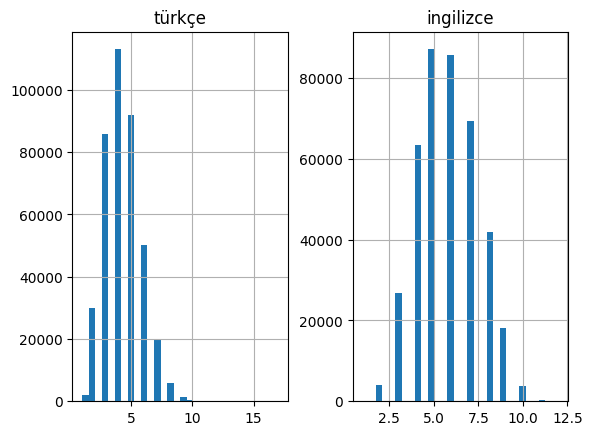

In [31]:
# Noktalama işaretlerini temizleme
tr_en[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in tr_en[:,0]]
tr_en[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in tr_en[:,1]]

# Tüm harfleri küçük harfe dönüştürme
for i in range(len(tr_en)):
    tr_en[i,0] = tr_en[i,0].lower()
    tr_en[i,1] = tr_en[i,1].lower()

tr_en

tr_list = []
en_list = []

# populate the lists with sentence lengths
for i in tr_en[:,0]:
    en_list.append(len(i.split()))

for i in tr_en[:,1]:
    tr_list.append(len(i.split()))

print('Maksimum türkçe cümle uzunluğu: ', max(tr_list))
print('Maksimum ingilizce cümle uzunluğu: ', max(en_list))
length_df = pd.DataFrame({'türkçe':tr_list, 'ingilizce':en_list})
length_df.hist(bins = 30)
plt.show()

In [32]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# prepare turkish tokenizer
tr_tokenizer = tokenization(tr_en[:, 1])
tr_vocab_size = len(tr_tokenizer.word_index) + 1
max_tr_length = max(tr_list)

print('Türkçe sözlük kapasitesi: %d' % tr_vocab_size)

# prepare English tokenizer
en_tokenizer = tokenization(tr_en[:, 0])
en_vocab_size = len(en_tokenizer.word_index) + 1
max_en_length = max(en_list)

print('İngilizce sözlük kapasitesi: %d' % en_vocab_size)

Türkçe sözlük kapasitesi: 77033
İngilizce sözlük kapasitesi: 18635


In [33]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## Eğitim ve Test Verisi Oluşturma

In [34]:
train,test= train_test_split(tr_en,test_size=0.2,random_state= 12)

# Eğitim verisini hazırlama
trainX = encode_sequences(tr_tokenizer, max_tr_length, train[:, 1])
trainY = encode_sequences(en_tokenizer, max_en_length, train[:, 0])

# Test verisini hazırlama
testX = encode_sequences(tr_tokenizer, max_tr_length, test[:, 1])
testY = encode_sequences(en_tokenizer, max_en_length, test[:, 0])

## Model Oluşturma

Keras ile basit modellerin oluşturulmasında **sıralı model (sequential model)** kullanılmaktadır. Daha karmaşık modellerin oluşturulmasında ise keras işlevsel API'si tercih edilmektedir. Bu proje kapsamında keras sıralı modeli kullanılacaktır.

Keras sıralı modeli oluşturulurken izlenecek adımlar sırasıyla aşağıdaki gibidir;

* Model mimarisini belirleme
* Modeli derleme (compile)
* Modeli eğitme (fit)
* Model performansını hesaplama

In [35]:
#  RNN ile Seq2seq (Diziden diziye) Modeli Oluşturma
def build_rnn_model(in_vocab,out_vocab, in_timesteps, out_timesteps, n):
    # Sıralı Modelin Oluşturulması
    model = Sequential()
    # Gömme katmanı - metin verilerini derin öğrenme modelleri için uygun bir formata dönüştürmek, anlamsal bilgiyi yakalamak ve modelin genel performansını artırmak amacıyla kullanılır.
    '''
    ▪ input_dim: Girdi dizilerinin kelime dağarcığı boyutudur.
    ▪ output_dim: Çıktı dizilerinin kelime dağarcığı boyutudur.
    ▪ input_length: Girdi dizilerinin uzunluğu.
    ▪ input_length: Ağın değişken uzunluktaki dizileri işlemesini sağlar.
    '''
    model.add(Embedding(in_vocab, n, input_length=in_timesteps, mask_zero=True))
#     model.add(Dropout(0.2))
    model.add(SimpleRNN(n))
#     model.add(Dropout(0.2))
    model.add(RepeatVector(out_timesteps))
    model.add(SimpleRNN(n, return_sequences=True))
#     model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

#  LSTM ile Seq2seq (Diziden diziye) Modeli Oluşturma
def build_lstm_model(in_vocab,out_vocab, in_timesteps, out_timesteps, n):
    model = Sequential()
    model.add(Embedding(in_vocab, n, input_length=in_timesteps, mask_zero=True))
#     model.add(Dropout(0.2))
    model.add(LSTM(n))
#     model.add(Dropout(0.2))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(n, return_sequences=True))
#     model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

#  GRU ile Seq2seq (Diziden diziye) Modeli Oluşturma
def build_gru_model(in_vocab, out_vocab, in_timesteps, out_timesteps, n):
    model = Sequential()
    # Embedding layer
    model.add(Embedding(in_vocab, n, input_length=in_timesteps, mask_zero=True))
    # Dropout for regularization
#     model.add(Dropout(0.2))
    # GRU layer
    model.add(GRU(n))
    # Dropout for regularization
#     model.add(Dropout(0.2))
    # RepeatVector for seq2seq
    model.add(RepeatVector(out_timesteps))
    # GRU layer with return_sequences=True for the decoder part
    model.add(GRU(n, return_sequences=True))
    # Dropout for regularization
#     model.add(Dropout(0.2))
    # Dense layer for output
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [36]:
# model compilation (with 512 hidden units)
rnn_model = build_rnn_model(tr_vocab_size, en_vocab_size, max_tr_length, max_en_length, 512)
lstm_model = build_lstm_model(tr_vocab_size, en_vocab_size, max_tr_length, max_en_length, 512)
gru_model = build_gru_model(tr_vocab_size, en_vocab_size, max_tr_length, max_en_length, 512)

rms = optimizers.legacy.RMSprop(learning_rate=0.001)

rnn_model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
lstm_model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
gru_model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

Model mimarisi aşağıda görüldüğü şekilde çizilebilir;

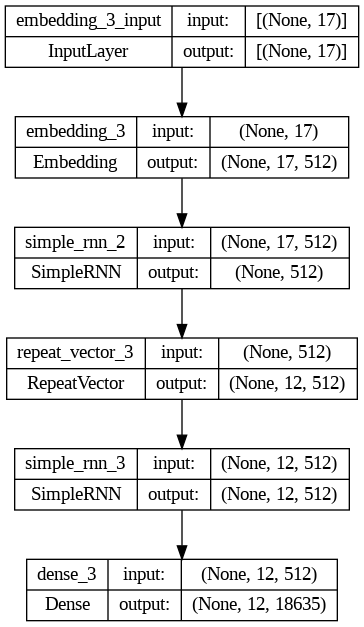

In [37]:
plot_model(rnn_model, "RNN modeli.png", show_shapes=True, show_layer_names=True)

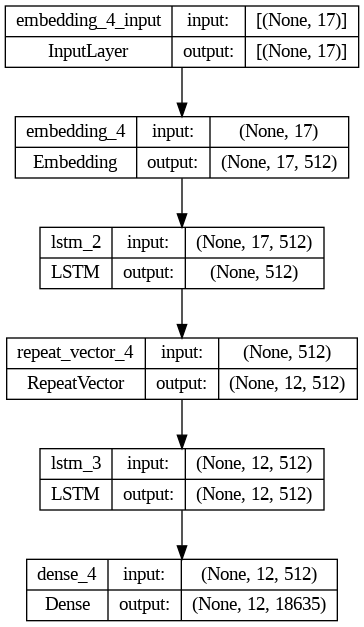

In [38]:
plot_model(lstm_model, "LSTM modeli.png", show_shapes=True, show_layer_names=True)

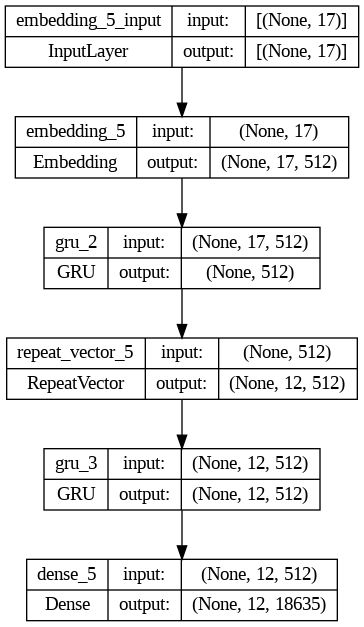

In [39]:
plot_model(gru_model, "GRU modeli.png", show_shapes=True, show_layer_names=True)

In [40]:
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 17, 512)           39440896  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 512)               524800    
                                                                 
 repeat_vector_3 (RepeatVec  (None, 12, 512)           0         
 tor)                                                            
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 12, 512)           524800    
                                                                 
 dense_3 (Dense)             (None, 12, 18635)         9559755   
                                                                 
Total params: 50050251 (190.93 MB)
Trainable params: 50050251 (190.93 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [41]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 17, 512)           39440896  
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 repeat_vector_4 (RepeatVec  (None, 12, 512)           0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 12, 512)           2099200   
                                                                 
 dense_4 (Dense)             (None, 12, 18635)         9559755   
                                                                 
Total params: 53199051 (202.94 MB)
Trainable params: 53199051 (202.94 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [42]:
gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 17, 512)           39440896  
                                                                 
 gru_2 (GRU)                 (None, 512)               1575936   
                                                                 
 repeat_vector_5 (RepeatVec  (None, 12, 512)           0         
 tor)                                                            
                                                                 
 gru_3 (GRU)                 (None, 12, 512)           1575936   
                                                                 
 dense_5 (Dense)             (None, 12, 18635)         9559755   
                                                                 
Total params: 52152523 (198.95 MB)
Trainable params: 52152523 (198.95 MB)
Non-trainable params: 0 (0.00 Byte)
__________

## Modelin Eğitilmesi

In [43]:
def train_and_save_model(model, trainX, trainY, model_name, filename, epochs, batch_size):
    start_time = time.time()
    # Aşırı uyum (overfitting) sorununu önlemek amacıyla EarlyStopping kullanıyoruz
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                        epochs=epochs, batch_size=batch_size, validation_split=0.2,
                        verbose=1, callbacks=[early_stopping])

    end_time = time.time()
    elapsed_time_minutes = (end_time - start_time) / 60

    print(f"{model_name} Modelinin eğitilmesi {elapsed_time_minutes:.2f} dakika sürdü.")

    model.save(filename)

    return history

### RNN modelinin eğitilmesi

In [44]:
rnn_history = train_and_save_model(rnn_model, trainX, trainY, "RNN", rnn_filename, epochs, batch_size)

Epoch 1/20
500/500 [==============================] - 99s 195ms/step - loss: 2.8555 - accuracy: 0.5800 - val_loss: 2.3489 - val_accuracy: 0.6256
Epoch 2/20
500/500 [==============================] - 97s 195ms/step - loss: 2.0367 - accuracy: 0.6579 - val_loss: 1.8571 - val_accuracy: 0.6741
Epoch 3/20
500/500 [==============================] - 97s 195ms/step - loss: 1.6486 - accuracy: 0.6979 - val_loss: 1.6143 - val_accuracy: 0.7012
Epoch 4/20
500/500 [==============================] - 97s 195ms/step - loss: 1.4338 - accuracy: 0.7222 - val_loss: 1.4967 - val_accuracy: 0.7153
Epoch 5/20
500/500 [==============================] - 97s 195ms/step - loss: 1.2918 - accuracy: 0.7404 - val_loss: 1.4301 - val_accuracy: 0.7232
Epoch 6/20
500/500 [==============================] - 97s 195ms/step - loss: 1.1849 - accuracy: 0.7552 - val_loss: 1.3934 - val_accuracy: 0.7262
Epoch 7/20
500/500 [==============================] - 97s 195ms/step - loss: 1.1002 - accuracy: 0.7682 - val_loss: 1.3568 - val_ac

### LSTM modelinin eğitilmesi

In [45]:
lstm_history = train_and_save_model(lstm_model, trainX, trainY, "LSTM", lstm_filename, epochs, batch_size)

Epoch 1/20
500/500 [==============================] - 111s 214ms/step - loss: 2.9483 - accuracy: 0.5615 - val_loss: 2.5568 - val_accuracy: 0.5939
Epoch 2/20
500/500 [==============================] - 106s 212ms/step - loss: 2.2959 - accuracy: 0.6232 - val_loss: 2.0675 - val_accuracy: 0.6494
Epoch 3/20
500/500 [==============================] - 106s 212ms/step - loss: 1.8489 - accuracy: 0.6739 - val_loss: 1.7543 - val_accuracy: 0.6861
Epoch 4/20
500/500 [==============================] - 106s 212ms/step - loss: 1.5479 - accuracy: 0.7089 - val_loss: 1.5441 - val_accuracy: 0.7109
Epoch 5/20
500/500 [==============================] - 106s 212ms/step - loss: 1.3383 - accuracy: 0.7357 - val_loss: 1.4201 - val_accuracy: 0.7286
Epoch 6/20
500/500 [==============================] - 106s 212ms/step - loss: 1.1832 - accuracy: 0.7573 - val_loss: 1.3291 - val_accuracy: 0.7399
Epoch 7/20
500/500 [==============================] - 106s 212ms/step - loss: 1.0620 - accuracy: 0.7758 - val_loss: 1.2864 -

### GRU modelinin eğitilmesi

In [46]:
gru_history = train_and_save_model(gru_model, trainX, trainY, "GRU", gru_filename, epochs, batch_size)

Epoch 1/20
500/500 [==============================] - 106s 205ms/step - loss: 2.8618 - accuracy: 0.5729 - val_loss: 2.3818 - val_accuracy: 0.6153
Epoch 2/20
500/500 [==============================] - 102s 204ms/step - loss: 2.0788 - accuracy: 0.6484 - val_loss: 1.8588 - val_accuracy: 0.6738
Epoch 3/20
500/500 [==============================] - 102s 204ms/step - loss: 1.6498 - accuracy: 0.6973 - val_loss: 1.5748 - val_accuracy: 0.7083
Epoch 4/20
500/500 [==============================] - 102s 204ms/step - loss: 1.3866 - accuracy: 0.7299 - val_loss: 1.4243 - val_accuracy: 0.7262
Epoch 5/20
500/500 [==============================] - 102s 205ms/step - loss: 1.2084 - accuracy: 0.7547 - val_loss: 1.3339 - val_accuracy: 0.7410
Epoch 6/20
500/500 [==============================] - 102s 204ms/step - loss: 1.0774 - accuracy: 0.7748 - val_loss: 1.2847 - val_accuracy: 0.7483
Epoch 7/20
500/500 [==============================] - 102s 204ms/step - loss: 0.9732 - accuracy: 0.7916 - val_loss: 1.2437 -

## Model Performanslarının Değerlendirilmesi

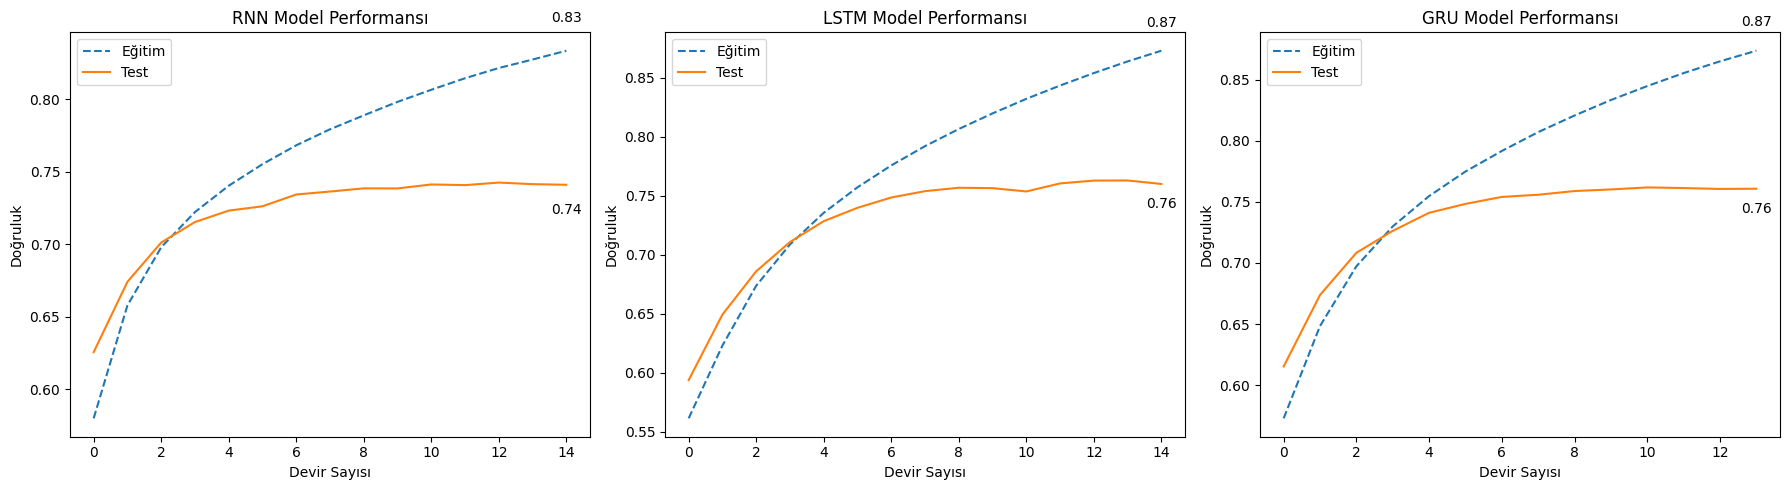

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Function to annotate the last point
def annotate_last_point(ax, x, y_train, y_val, offset=0.02):
    ax.text(len(x)-1, y_train[-1] + offset, f'{y_train[-1]:.2f}', ha='center')
    ax.text(len(x)-1, y_val[-1] - offset, f'{y_val[-1]:.2f}', ha='center')

# RNN Plot
x = range(len(rnn_history.history["accuracy"]))
axs[0].plot(x, rnn_history.history["accuracy"], "--")
axs[0].plot(x, rnn_history.history["val_accuracy"])
axs[0].set_title("RNN Model Performansı")
axs[0].set_ylabel("Doğruluk")
axs[0].set_xlabel("Devir Sayısı")
axs[0].legend(["Eğitim", "Test"], loc="upper left")
annotate_last_point(axs[0], x, rnn_history.history["accuracy"], rnn_history.history["val_accuracy"])

# LSTM Plot
x = range(len(lstm_history.history["accuracy"]))
axs[1].plot(x, lstm_history.history["accuracy"], "--")
axs[1].plot(x, lstm_history.history["val_accuracy"])
axs[1].set_title("LSTM Model Performansı")
axs[1].set_ylabel("Doğruluk")
axs[1].set_xlabel("Devir Sayısı")
axs[1].legend(["Eğitim", "Test"], loc="upper left")
annotate_last_point(axs[1], x, lstm_history.history["accuracy"], lstm_history.history["val_accuracy"])

# GRU Plot
x = range(len(gru_history.history["accuracy"]))
axs[2].plot(x, gru_history.history["accuracy"], "--")
axs[2].plot(x, gru_history.history["val_accuracy"])
axs[2].set_title("GRU Model Performansı")
axs[2].set_ylabel("Doğruluk")
axs[2].set_xlabel("Devir Sayısı")
axs[2].legend(["Eğitim", "Test"], loc="upper left")
annotate_last_point(axs[2], x, gru_history.history["accuracy"], gru_history.history["val_accuracy"])

plt.tight_layout()
plt.show()

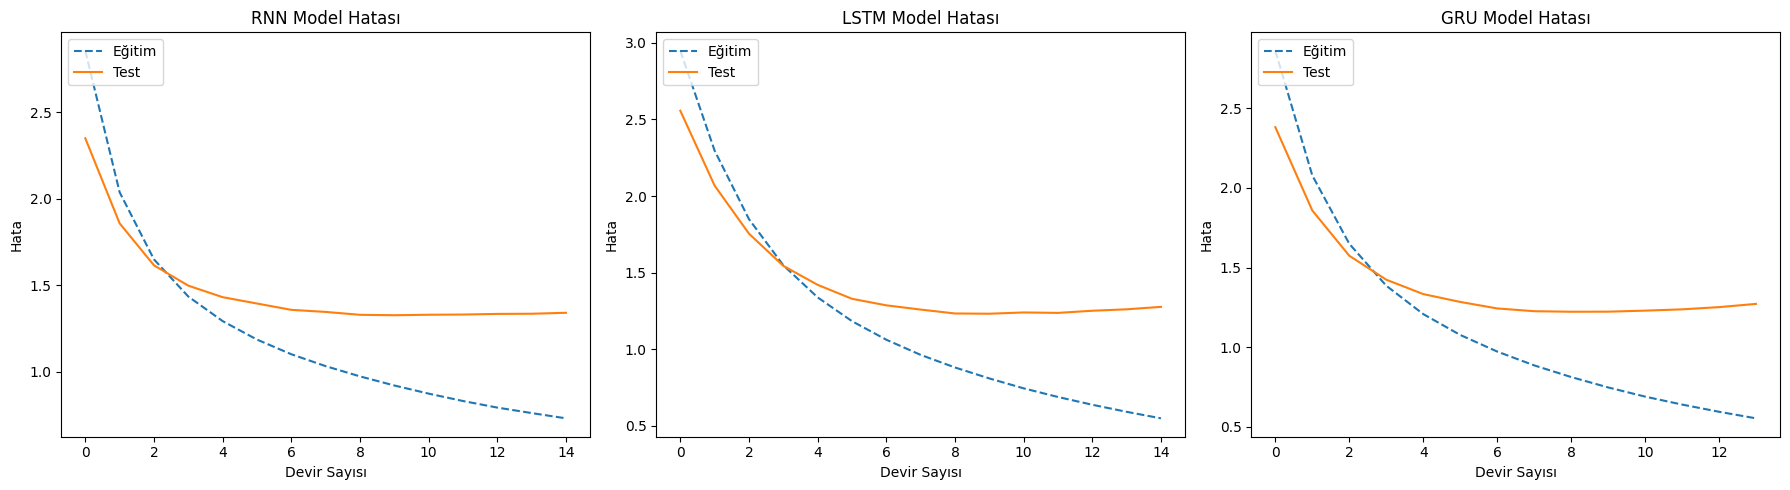

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RNN Plot
axs[0].plot(rnn_history.history["loss"], "--")
axs[0].plot(rnn_history.history["val_loss"])
axs[0].set_title("RNN Model Hatası")
axs[0].set_ylabel("Hata")
axs[0].set_xlabel("Devir Sayısı")
axs[0].legend(["Eğitim", "Test"], loc="upper left")

# LSTM Plot
axs[1].plot(lstm_history.history["loss"], "--")
axs[1].plot(lstm_history.history["val_loss"])
axs[1].set_title("LSTM Model Hatası")
axs[1].set_ylabel("Hata")
axs[1].set_xlabel("Devir Sayısı")
axs[1].legend(["Eğitim", "Test"], loc="upper left")

# GRU Plot
axs[2].plot(gru_history.history["loss"], "--")
axs[2].plot(gru_history.history["val_loss"])
axs[2].set_title("GRU Model Hatası")
axs[2].set_ylabel("Hata")
axs[2].set_xlabel("Devir Sayısı")
axs[2].legend(["Eğitim", "Test"], loc="upper left")

plt.tight_layout()
plt.show()

## Eğitilen Modelin Tahmin İçin Kullanılması

In [50]:
loaded_rnn_model = load_model(rnn_filename, compile=False)

loaded_rnn_model.summary()

rnn_predictions = loaded_rnn_model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

ResourceExhaustedError: ignored

In [ ]:
loaded_lstm_model = load_model(lstm_filename, compile=False)

loaded_lstm_model.summary()

lstm_predictions = loaded_lstm_model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

In [ ]:
loaded_gru_model = load_model(gru_filename, compile=False)

loaded_gru_model.summary()

gru_predictions = loaded_gru_model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

def get_preds_text(predictions, tokenizer):
    preds = np.argmax(predictions, axis=-1)
    preds_text = []
    for i in preds:
        temp = []
        for j in range(len(i)):
            t = get_word(i[j], tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], tokenizer)) or (t == None):
                    temp.append('')
                else:
                    temp.append(t)
            else:
                if(t == None):
                    temp.append('')
                else:
                    temp.append(t)
        preds_text.append(' '.join(temp))
    return preds_text

rnn_preds_text = get_preds_text(rnn_predictions, en_tokenizer)
lstm_preds_text = get_preds_text(lstm_predictions, en_tokenizer)
gru_preds_text = get_preds_text(gru_predictions, en_tokenizer)

pred_df = pd.DataFrame({
    'Türkçe': test[:, 1],
    'İngilizce': test[:, 0],
    'RNN Tahmin': rnn_preds_text,
    'LSTM Tahmin': lstm_preds_text,
    'GRU Tahmin': gru_preds_text
})

sample_indices = pred_df.sample(15).index
displayed_samples = pred_df.loc[sample_indices]
print(displayed_samples)

In [ ]:
def calculate_bleu_scores(references, candidates):
    chencherry = SmoothingFunction()

    # Initialize scores for 1-gram to 4-gram
    scores_1gram = []
    scores_2gram = []
    scores_3gram = []
    scores_4gram = []
    scores_cumulative = []

    for ref, cand in zip(references, candidates):
        ref_list = [ref.split()]
        cand_list = cand.split()

        scores_1gram.append(sentence_bleu(ref_list, cand_list, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1))
        scores_2gram.append(sentence_bleu(ref_list, cand_list, weights=(0, 1, 0, 0), smoothing_function=chencherry.method1))
        scores_3gram.append(sentence_bleu(ref_list, cand_list, weights=(0, 0, 1, 0), smoothing_function=chencherry.method1))
        scores_4gram.append(sentence_bleu(ref_list, cand_list, weights=(0, 0, 0, 1), smoothing_function=chencherry.method1))
        scores_cumulative.append(sentence_bleu(ref_list, cand_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1))

    return {
        "1-gram": sum(scores_1gram) / len(scores_1gram),
        "2-gram": sum(scores_2gram) / len(scores_2gram),
        "3-gram": sum(scores_3gram) / len(scores_3gram),
        "4-gram": sum(scores_4gram) / len(scores_4gram),
        "Cumulative": sum(scores_cumulative) / len(scores_cumulative)
    }

references = test[:, 0]

rnn_bleu_scores = calculate_bleu_scores(references, get_preds_text(rnn_predictions, en_tokenizer))
lstm_bleu_scores = calculate_bleu_scores(references, get_preds_text(lstm_predictions, en_tokenizer))
gru_bleu_scores = calculate_bleu_scores(references, get_preds_text(gru_predictions, en_tokenizer))

print("RNN BLEU Puanı:")
for key, value in rnn_bleu_scores.items():
    print(f"{key}: {value:.4f}")

print("\nLSTM BLEU Puanı:")
for key, value in lstm_bleu_scores.items():
    print(f"{key}: {value:.4f}")

print("\nGRU BLEU Puanı:")
for key, value in gru_bleu_scores.items():
    print(f"{key}: {value:.4f}")